# Simple ARIMA model for non-seasonal time-serie forecast

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;

##  1. Load Data
Let's start by loading the time series of the challenge

<AxesSubplot:>

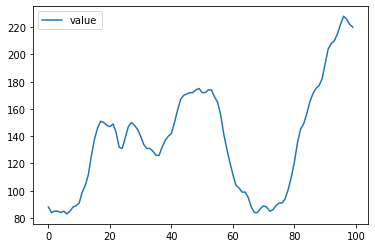

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('data/wwwusage.csv', names=['value'], header=0)
y = df.value
df.plot()

In [4]:
x_val = df['value']

This abstract time serie does not seem seasonal, but with some increasing trend and somehow "sticky" (i.e. with some auto-regressivity). So it may be a good candidate for Auto-Regresive Moving Average (ARIMA) models


## 2. Build ARIMA model
We will try to forecast the data thanks to ARIMA models (Auto Regressive Integrated Moving Average).

For that, we will need to :
1. find how to stationarize the time serie (I in SARIMA)
2. find the auto-regressive (AR) part
3. find the Moving-Average (MA) part
4. Fit
5. Assess performance

### Step 1 - Ensure stationarity

ARIMA models applies to "stationary" time series only.

üëâ Check its stationarity precisely using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), and especially its p-value

In [5]:
from statsmodels.tsa.stattools import adfuller
ad_fuller_result = adfuller(x_val)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.464239717203365
p-value: 0.12441935447109559


In [6]:
adfuller(x_val, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)

(-2.464239717203365,
 0.12441935447109559,
 3,
 96,
 {'1%': -3.5003788874873405,
  '5%': -2.8921519665075235,
  '10%': -2.5830997960069446},
 444.67104090432554)

The p-value should be  less than 0.05 to have a 95% confidence in the stationarity.  
If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

If the time series is not stationary, it needs to be stationarized through **differencing**. 
- It means that we take the difference between each value and the preceding one (*first difference*).
- Repeat process on the differentiated serie if you want the *second difference*, etc...

üëâ Find the minimum order of differencing we need to make it stationnary (plot the curves to visualize them, and print their adfuller p-value to be sure)

<details>
    <summary>Hint</summary>

`pd.Series.diff`
</details>

In [7]:
import numpy as np
df['data'] = np.log(x_val)
df['data'] = x_val.diff()

In [8]:
df

value  data
0      88   NaN
1      84  -4.0
2      85   1.0
3      85   0.0
4      84  -1.0
..    ...   ...
95    222   7.0
96    228   6.0
97    226  -2.0
98    222  -4.0
99    220  -2.0

[100 rows x 2 columns]

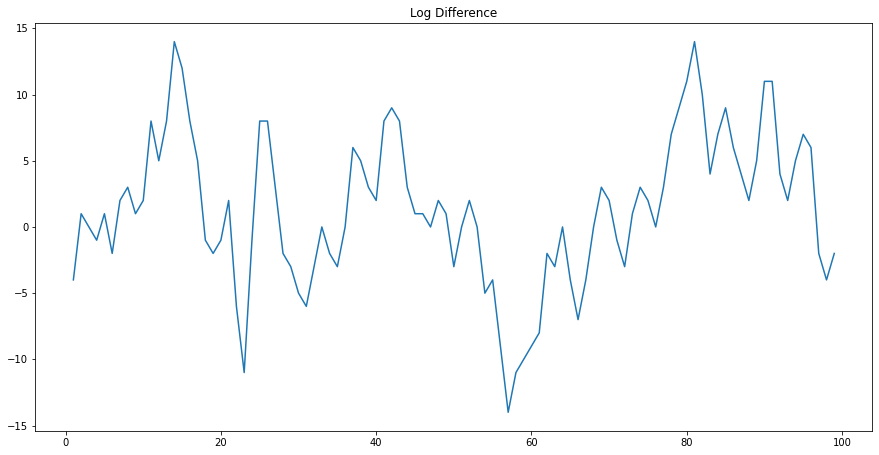

In [9]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(df['data'])
plt.title("Log Difference")
plt.show()

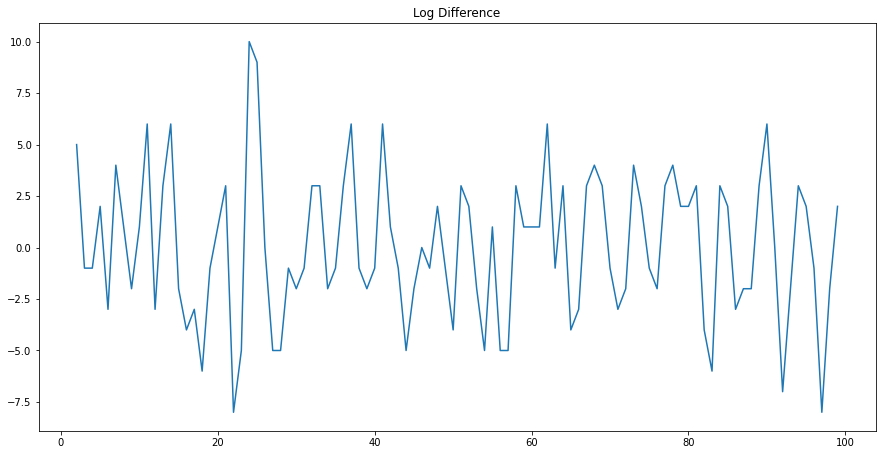

In [10]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(df['data'].diff())
plt.title("Log Difference")
plt.show()

In [11]:
dfc = df[(df['data']>=0) | (df['data']<= 0)]


In [12]:
ad_fuller_result = adfuller(dfc['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.722238490442953
p-value: 0.07026846015272707


In [13]:
dfc['data2'] = np.log(dfc['data'])
dfc['data2'] = dfc['data'].diff()
dfc

C:\Users\Joe\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Joe\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Joe\AppData\Local\Temp/ipykernel_1400/3865458623.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc['data2'] = np.log(dfc['data'])
C:\Users\Joe\AppData\Local\Temp/ipykernel_1400/3865458623.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

value  data  data2
1      84  -4.0    NaN
2      85   1.0    5.0
3      85   0.0   -1.0
4      84  -1.0   -1.0
5      85   1.0    2.0
..    ...   ...    ...
95    222   7.0    2.0
96    228   6.0   -1.0
97    226  -2.0   -8.0
98    222  -4.0   -2.0
99    220  -2.0    2.0

[99 rows x 3 columns]

In [14]:
dfc = dfc[(dfc['data2']>=0) | (dfc['data2']<= 0)]


In [15]:
ad_fuller_result = adfuller(dfc['data2'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -9.929762173626017
p-value: 2.8434287555470966e-17


We have a close-call here between one and two diff orders. Differentiating too much a time series may also reduce performance of your ARIMA models. Let's have a closer look:

üëâ Plot autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) for diff order 1 and 2.

(üí°Pro tip: Avoid duplicating statsmodels plots by calling `plt.show()` or by adding `;` to the end of each instantiation of a statsmodels plot)

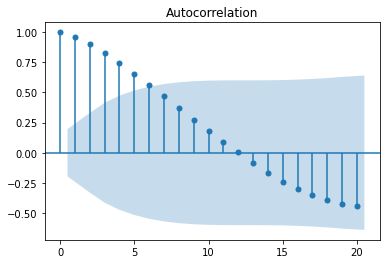

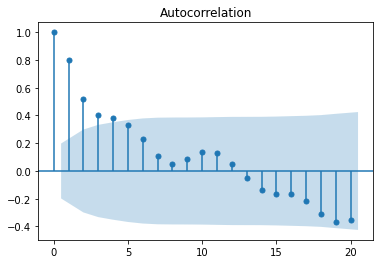

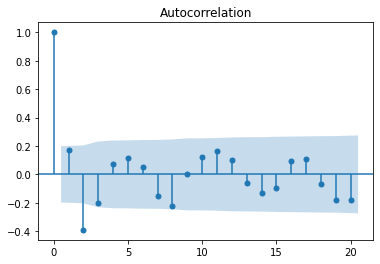

In [16]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(x_val);
plot_acf(dfc['data']);
plot_acf(dfc['data2']);

In our "second order diff" autocorrelation plot, the lag coefficient n¬∞1 is close to 0, while the second one escapes far into negative territory. This might indicate we have over-differentiated the series. (Remember: we never care about the lag n¬∞0 which is always equal to 1)

üëâ Let's (temptatively) keep only one diff order and name this series `y_diff` (we can always try more diff later)

In [17]:
y_diff = dfc['data']

We just found the term "I" in ARIMA: `d = 1` for 1-diff before stationary (I refers to "integration", "d" for differentiation...)


### Step 2 - Select AR order (p) and MA order (q)

#### MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d)}}$ cuts off

MA order (`q`) can be found by looking at the autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to`y_diff`. 

üëâ determine `q`

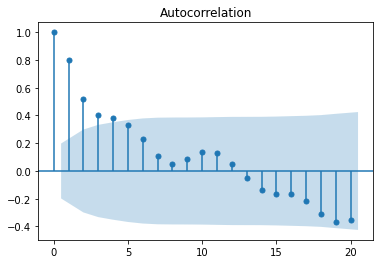

In [18]:
plot_acf(y_diff);

We could choose q = 4, but it's more conservatively to try with `q=2` to start with.

When in doubt, go with the simpler model that sufficiently explains the Y.

#### AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d)}}$  cuts off

AR order (`p`) can be found by investigating the **p**artial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to `y_diff`.

(Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series)

üëâ Determine `p`

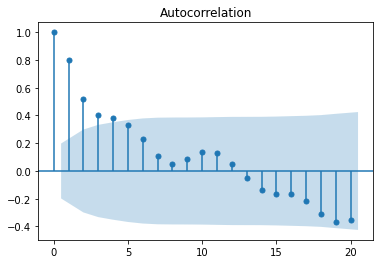

In [19]:
plot_acf(y_diff);

We could choose `p = 3` as the first 3 lag terms seems above the significance level, but we could also go with a simpler model `p = 1`. 



### Step 3 - Build the model

Now that you have chosen the values for `p`, ` d` and `q` for the ARIMA, 

üëâ build the `arima_model` from `statsmodels`.
- fit the the model
- print the model (`.summary`)

In [20]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y_diff , order=(3,1,2)).fit()

C:\Users\Joe\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Joe\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Joe\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\Joe\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting p

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   data   No. Observations:                   98
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -246.982
Date:                Tue, 04 Jan 2022   AIC                            505.964
Time:                        15:31:59   BIC                            521.412
Sample:                             0   HQIC                           512.210
                                 - 98                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1373      0.337      3.373      0.001       0.476       1.798
ar.L2         -0.6380      0.368     -1.734      0.083      -1.359       0.083
ar.L3          0.3349      0.158      2.121      0.034       0.025       0.644
ma.L1         -0.9716      1.698     -0.572      0.567      -4.299       2.355
ma.L2         -0.0275      0.315     -0.087      0.930      -0.645       0.590
sigma2         9.2830     14.775      0.628      0.530     -19.676      38.242
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.21
Prob(Q):                              0.98   Prob(JB):                         0.90
Heteroskedasticity (H):               0.54   Skew:                            -0.11
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

‚òùÔ∏è If your p-values are too high, try remove these terms by reducing the corresponding AR or SA coefficients.

You can evaluate overall performance of your fit by minimizing the [`AIC - akaike information criterion`](https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2) value

It seems that the (1,1,1) ARIMA models have less chance of overfitting (p-values remains low) and maintain a quasi similar AIC score than other models

## 3. Evaluate model performance

üëâ Visualize your model predictions with `.plot_predict()`

- Look closely at the method default params, especially `dynamic`. 
- Do you think your model would have such good performance in reality?

In [1]:
import statsmodels
statsmodels.__version__

'0.12.1'

In [45]:
pip uninstall statsmodels

^C
Note: you may need to restart the kernel to use updated packages.


In [25]:
from statsmodels.tsa.arima_model import ARIMA


In [26]:
model.plot_predict(dynamic=False)
plt.show()

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'

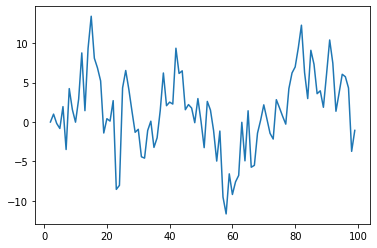

In [37]:
plt.plot(model.predict());

‚òùÔ∏è `dynamic=False` actually makes use of all available values `y` in order to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

üëâ Try to use `dynamic=True` to plot a prection of the _last 15 values_ in a situation where the model only have _access to data up to 85_. That is to say, the model:
- predicts 86 based on true [1...85]
- then predicts 87 based on [1...85] _plus_ it's previouly predicted value for 86
- etc...iteratively until 100

In [ ]:
plt.plot(model.predict());

‚òùÔ∏è That's still not a _true_ forecast!! Why??

<details>
    <summary>Answer</summary>

Our model has "seen" the whole `y_true` serie during the fitting phase!
</details>

### 3.1 Out-of-sample forecasts (real "future")

üëâ Create a train-test-split keep the last 15 datapoints only for the test set, and train your ARIMA on the train set only.

In [27]:
train = df.value[:85]
test = df.value[85:]

üëâ We are "now" in step 85 and have never seen the future:
- Use `.forecast()` method on your fitted model to "forecast" the 15 next datapoints (i.e beyond the end of your train dataset) 
- Plot forecasted values as well as the higher and lower range of 95% uncertainty interval

In [29]:
model = ARIMA(train, order=(1, 1, 1))

C:\Users\Joe\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [30]:
fitted = model.fit(disp=-1)  

In [31]:
fc, se, conf = fitted.forecast(15, alpha=0.05)

In [32]:
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

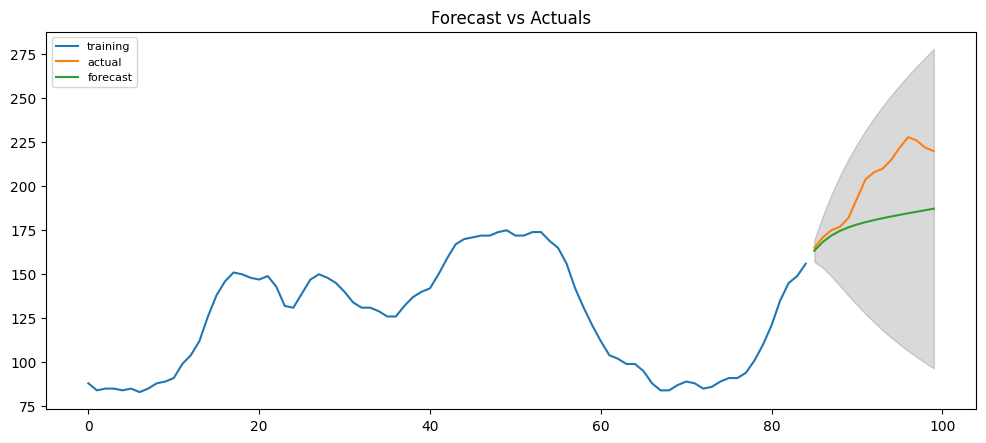

In [33]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

üëâ Try to also plot your previous 85 `y` real datapoints to better grasp model performance relative to the past

C:\Users\Joe\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   83
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -214.248
Method:                       css-mle   S.D. of innovations              3.153
Date:                Tue, 04 Jan 2022   AIC                            440.497
Time:                        16:49:13   BIC                            455.010
Sample:                             2   HQIC                           446.327
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0483      0.084      0.577      0.564      -0.116       0.212
ar.L1.D2.value     1.1386      0.109     10.399      0.000       0.924       1.353
ar.L2.D2.value    -0.5923      0.155

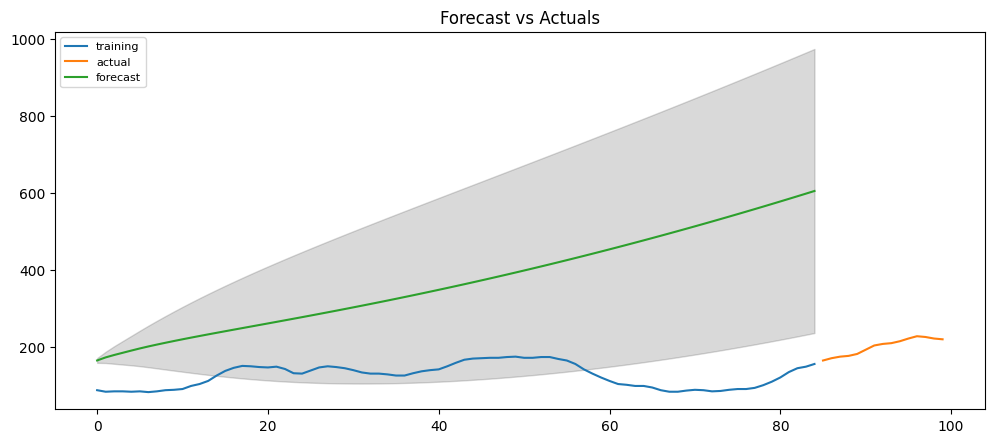

In [49]:
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(85, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=train.index)
lower_series = pd.Series(conf[:, 0], index=train.index)
upper_series = pd.Series(conf[:, 1], index=train.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


### 3.2 Can you trust your 95% confidence interval? (conditions for inference)

üëâ Plot the residuals `model.resid` to ensure there are no patterns
- Normally distributed
- Mean zero
- Uniform variance
- No autoregressive patterns (you can plot_acf the residuals if you really want)

Note: residuals are constructed by 'seing' all data as in `plot_predict(dynamic=False)`

Also try to plot a histogram or kde fit of the residuals to see if they are approximately normally distributed.

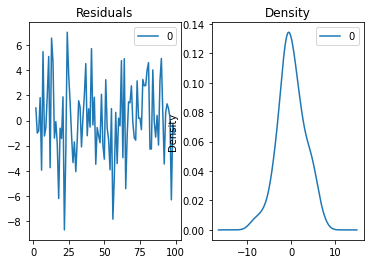

In [24]:
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

## 3.3 Cross-validated performance metrics

üëâ Below are the given the most common performance metrics for time series

In [40]:
test.values

array([165, 171, 175, 177, 182, 193, 204, 208, 210, 215, 222, 228, 226,
       222, 220], dtype=int64)

In [42]:
import numpy as np
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

üëâ Play with you ARIMA hyper-parameters and see the impact on your forecast performance

In [43]:
forecast_accuracy(fc, test.values)

C:\Users\Joe\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\Joe\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 0.022501295582823037,
 'me': 3.2307727178180623,
 'mae': 4.548318621396603,
 'mpe': 0.01642095249523604,
 'rmse': 6.373232745889553,
 'acf1': 0.5105508008004516,
 'corr': 0.967457646739258,
 'minmax': 0.021631531705504914}

## 4 Grid Search

Try to run your own gridsearch for (p,d,q) using `pmdarima`. Use at least
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [50]:
import pmdarima as pm
model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=525.587, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=533.474, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=532.437, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=525.893, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=531.477, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=515.248, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=513.459, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=515.284, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=511.465, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=530.444, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=513.291, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=513.256, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=523.592, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time

## (Optional) Cross-validate performance of your model?

In practice, Results and GridSearch should always be cross validated: 

Feel free to use [`sklearn.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create continguous K-folds so as to truely evaluate the performance of your model and find the best hyper-params after cross validation

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0101.png'>